Importing necessary libraries

In [ ]:
import cv2
import pandas
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
path1 = './samples/23n88.png'
path2 = './samples/23mdg.png'

In [ ]:
img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

In [ ]:
#Function for plotting two images
def plot_ (img1, img2) :
    plt.figure(figsize = (20,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img1, 'gray')
    
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(img2, 'gray')
    
    plt.axis('off')

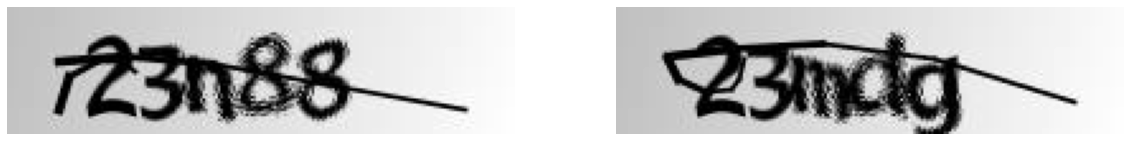

In [ ]:
plot_(img1, img2)

# Pre-Processing

**Adaptive Thresholding**-
Algorithms determine the threshold for a pixel based on its surrounding regions. So we get different thresholds for different regions of the same image which gives better result for images with varying illumination.

In [ ]:
thresh_img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
thresh_img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

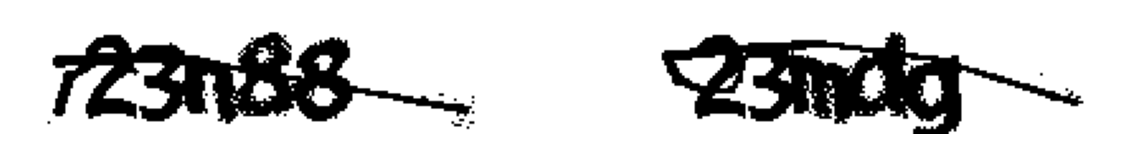

In [ ]:
plot_(thresh_img1, thresh_img2)

**Morphological transformations** - Closing is reverse of Opening, **Dilation followed by Erosion**. It is useful in closing small holes inside the foreground objects, or small black points on the object.

In [ ]:
close_img1 = cv2.morphologyEx(thresh_img1, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
close_img2 = cv2.morphologyEx(thresh_img2, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

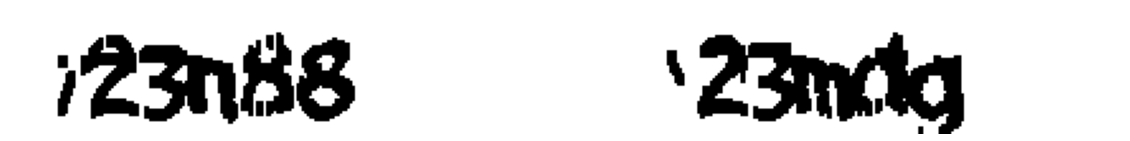

In [ ]:
plot_(close_img1, close_img2)

**Smoothing Images (Blurring)** 
Involves convolving a low-pass filter with an image, to remove high frequency components ie. noises and edges from the image.

In [ ]:
gauss_img1 = cv2.GaussianBlur(close_img1, (1,1), 0)
gauss_img2 = cv2.GaussianBlur(close_img2, (1,1), 0)

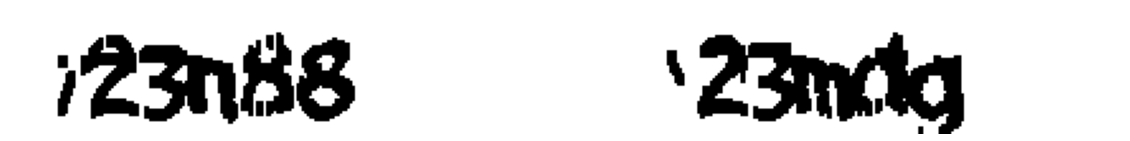

In [ ]:
plot_(gauss_img1, gauss_img2)

## Partitioning Batch Normalization

In [ ]:
cv2.rectangle(gauss_img1, (30,12), (50,49), 0, 1)
cv2.rectangle(gauss_img1, (50,12), (70,49), 0, 1)
cv2.rectangle(gauss_img1, (70,12), (90,49), 0, 1)
cv2.rectangle(gauss_img1, (90,12), (110,49),0, 1)
cv2.rectangle(gauss_img1, (110,12),(130,49),0, 1)

cv2.rectangle(gauss_img2, (30,12), (50,49), 0, 1)
cv2.rectangle(gauss_img2, (50,12), (70,49), 0, 1)
cv2.rectangle(gauss_img2, (70,12), (90,49), 0, 1)
cv2.rectangle(gauss_img2, (90,12), (110,49),0, 1)
cv2.rectangle(gauss_img2, (110,12),(130,49),0, 1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

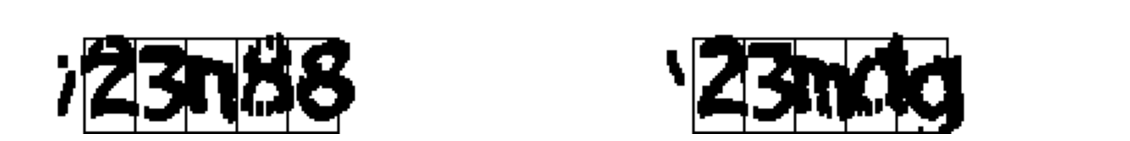

In [ ]:
plot_(gauss_img1, gauss_img2)

# Converting images to appropriate samples

In [ ]:
path = './samples/'

In [ ]:
def t_img (img) :
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

def c_img (img) :
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

#def d_img (img) :
#   return cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

def b_img (img) :
    return cv2.GaussianBlur(img, (1,1), 0)

In [ ]:
import os
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator

In [ ]:
X = []
y = []

for image in os.listdir(path) :
    
    if image[6:] != 'png' :
        continue
    
    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
    
    img = t_img(img)
    img = c_img(img)
    #img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    for i in range(5) :
        X.append(img_to_array(Image.fromarray(image_list[i])))
        y.append(image[i])
X = np.array(X)
y = np.array(y)

In [ ]:
print(X.shape)
print(y.shape)

(5200, 40, 20, 1)
(5200,)


# Initial Analysis and Data Wrangling

In [ ]:
#scale between 0 and 1
X /= 255.0

[]

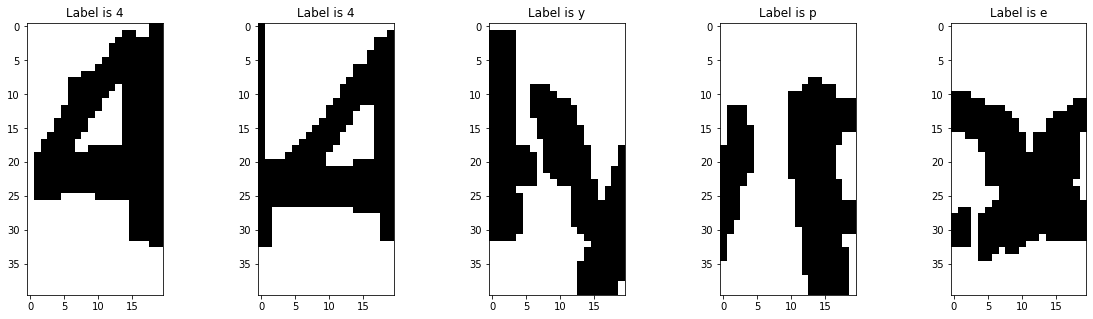

In [ ]:
plt.figure(figsize = (20,5))
for i in range(5) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.squeeze(X[i]), 'gray')
    plt.title('Label is ' + str(y[i]))
plt.plot()

In [ ]:
#One Hot Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [ ]:
info = {y_combine[i] : y[i] for i in range(len(y))}

# Train Test Split

In [ ]:
print(X.shape)
print(y_one_hot.shape)  # one hot encoded form

(5200, 40, 20, 1)
(5200, 19)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 1)

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(X_train)

In [ ]:
train_set = traingen.flow(X_train, y_train)
trainX, trainy = train_set.next()

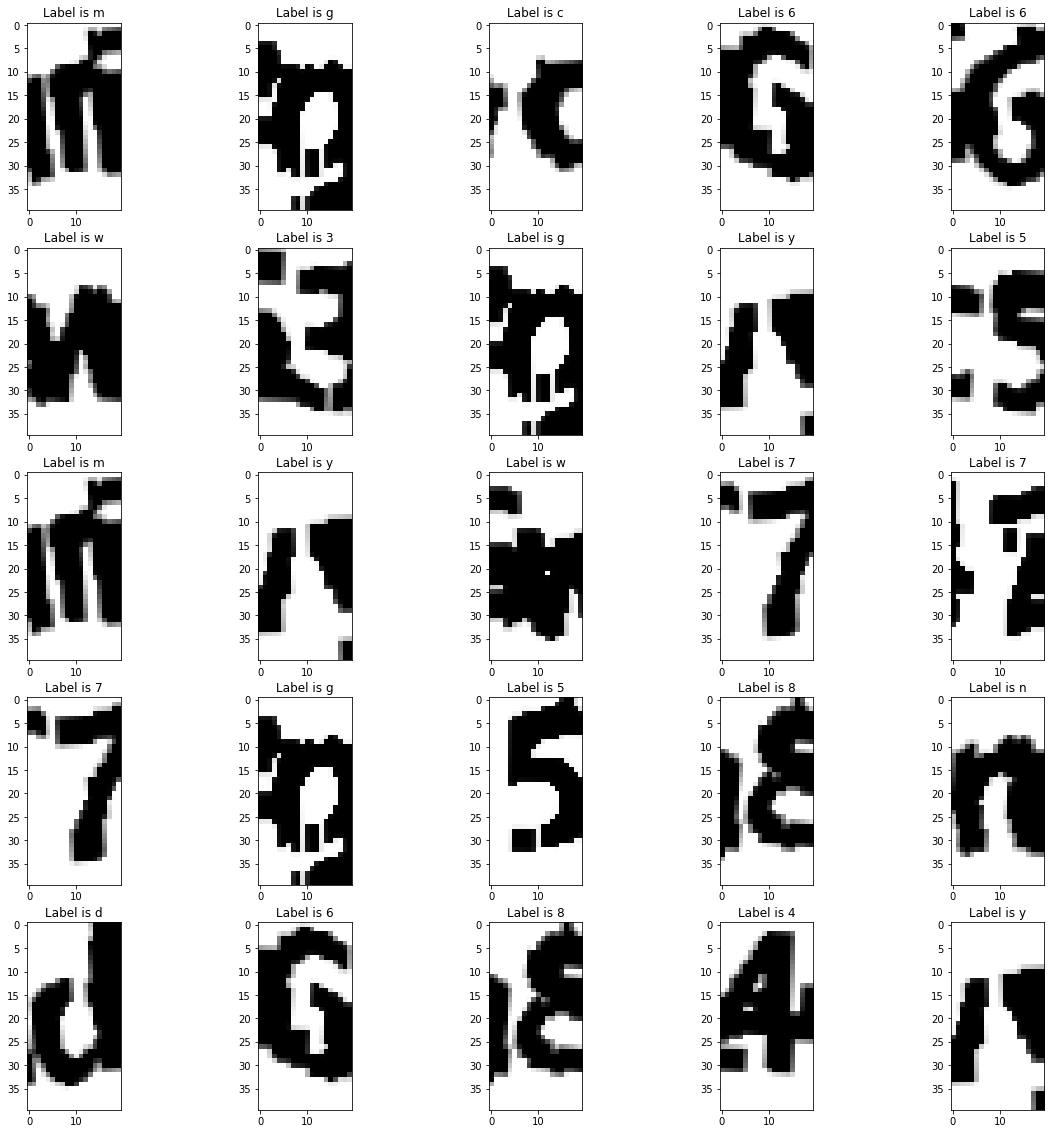

In [ ]:
plt.figure(figsize = (20,20))

hi = 32
lo = 0

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(tf.squeeze(trainX[x]), 'gray')
    plt.title('Label is ' + str(info[np.argmax(trainy[x])]))
plt.show()

# Modelling 

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

from keras.layers import Dropout
from keras.layers import Input

In [ ]:
print(X_train.shape)
print(y_train.shape)

(4160, 40, 20, 1)
(4160, 19)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(1040, 40, 20, 1)
(1040, 19)


In [ ]:
def conv_layer (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    
    return model

In [ ]:
def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [ ]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    model.add(Input((40, 20, 1,)))
    
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    
    model.add(Dense(19, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

# Model Training

In [ ]:
model = cnn(128, 32, 16, 32, 32)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 20, 10, 128)       1792      
                                                                 
 sequential_2 (Sequential)   (None, 10, 5, 32)         37024     
                                                                 
 sequential_3 (Sequential)   (None, 5, 3, 16)          4688      
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 sequential_4 (Sequential)   (None, 32)                7840      
                                                                 
 sequential_5 (Sequential)   (None, 32)                1184      
                                                                 
 dense_2 (Dense)             (None, 19)                6

**ModelCheckpoint and ReduceLROnPlateau**

Used ModelCheckpoint to retain the best perfroming model (in terms of loss), and ReduceLROnPlateau to reduce the learning in case the model stops improving.

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkp = ModelCheckpoint('/result_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

In [ ]:
reduce = ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1)

In [ ]:
history = model.fit(traingen.flow(X_train, y_train, batch_size = 32), validation_data = (X_test, y_test), epochs = 150, steps_per_epoch = len(X_train)/32, callbacks = [checkp])

Epoch 1/150
130/130 [==============================] - ETA: 0s - loss: 2.7185 - accuracy: 0.2070
Epoch 00001: val_loss improved from inf to 3.54123, saving model to /result_model.h5
130/130 [==============================] - 25s 178ms/step - loss: 2.7185 - accuracy: 0.2070 - val_loss: 3.5412 - val_accuracy: 0.0548
Epoch 2/150
130/130 [==============================] - ETA: 0s - loss: 1.8566 - accuracy: 0.4731
Epoch 00002: val_loss did not improve from 3.54123
130/130 [==============================] - 23s 177ms/step - loss: 1.8566 - accuracy: 0.4731 - val_loss: 3.6851 - val_accuracy: 0.0731
Epoch 3/150
130/130 [==============================] - ETA: 0s - loss: 1.4304 - accuracy: 0.6125
Epoch 00003: val_loss improved from 3.54123 to 2.87841, saving model to /result_model.h5
130/130 [==============================] - 23s 175ms/step - loss: 1.4304 - accuracy: 0.6125 - val_loss: 2.8784 - val_accuracy: 0.2308
Epoch 4/150
130/130 [==============================] - ETA: 0s - loss: 1.2132 - ac

Text(0.5, 1.0, 'Model accuracy wrt Epoch')

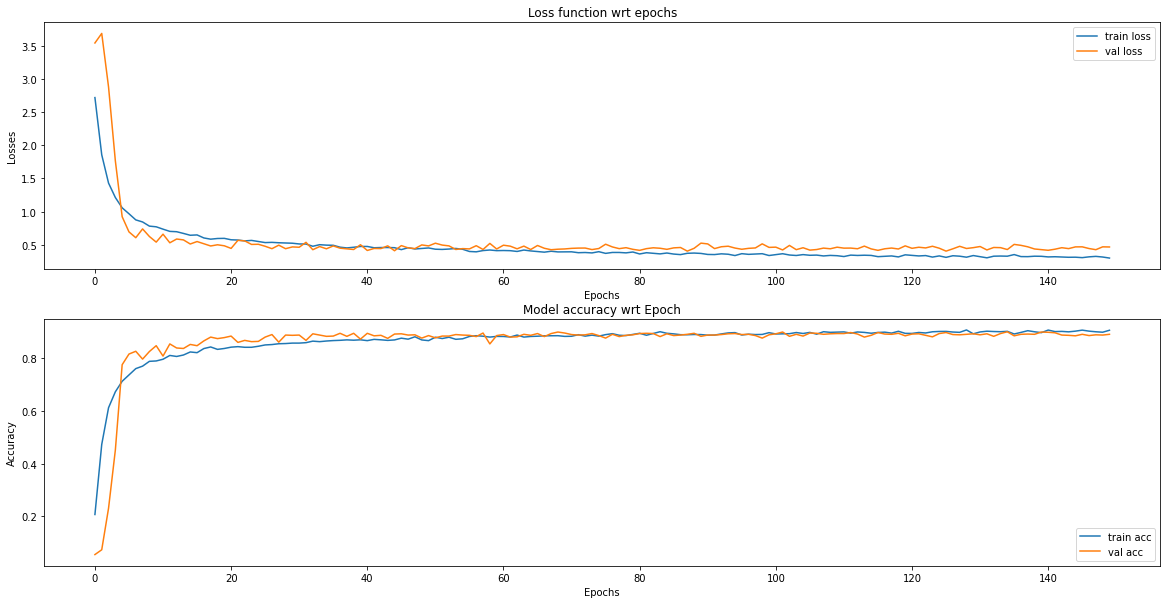

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')

# Testing

In [ ]:
from keras.models import load_model
model = load_model('/result_model.h5')
pred = model.predict(X_test)

In [ ]:
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
target_name = []
for i in sorted(info) :
    target_name.append(info[i])
target_name

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y']

In [ ]:
print('Accuracy : ' + str(accuracy_score(yres, pred)))
print(classification_report(yres, pred, target_names = target_name))

Accuracy : 0.8913461538461539
              precision    recall  f1-score   support

           2       0.98      0.96      0.97        49
           3       0.98      0.95      0.96        43
           4       0.95      0.91      0.93        57
           5       0.98      0.94      0.96        48
           6       0.91      0.98      0.94        51
           7       0.91      0.93      0.92        57
           8       0.98      0.98      0.98        65
           b       0.84      1.00      0.91        42
           c       0.94      0.63      0.76        52
           d       0.72      0.90      0.80        40
           e       0.98      0.86      0.91        56
           f       0.96      0.94      0.95        49
           g       0.93      0.98      0.95        52
           m       0.88      0.52      0.65        67
           n       0.68      0.93      0.79        99
           p       0.98      0.95      0.97        60
           w       0.80      0.85      0.83        

# Testing on Samples

In [ ]:
def get_demo (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    img = t_img(img)
    img = c_img(img)
    #img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    Xdemo = []
    for i in range(5) :
        Xdemo.append(img_to_array(Image.fromarray(image_list[i])))
    
    Xdemo = np.array(Xdemo)
    Xdemo/= 255.0
    
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 1)
    
    for res in ydemo :
        print(info[res])
    print(img_path[-9:])

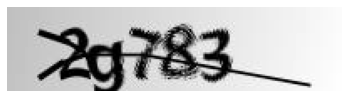

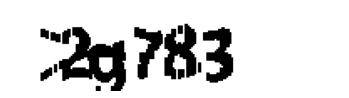

2
g
7
8
3
2g783.png


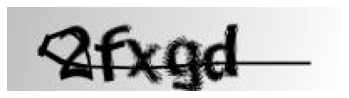

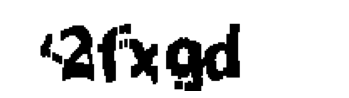

2
f
x
g
d
2fxgd.png


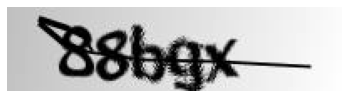

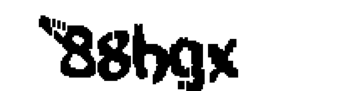

8
8
b
g
x
88bgx.png


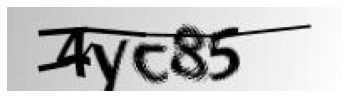

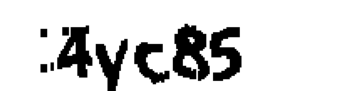

4
y
c
8
5
4yc85.png


In [ ]:
get_demo('./samples/2g783.png')
get_demo('./samples/2fxgd.png')
get_demo('./samples/88bgx.png')
get_demo('./samples/4yc85.png')